In [0]:
%tensorflow_version 1.x
import tensorflow

In [0]:
import json
import numpy as np
import operator
import os
import pandas as pd
import re

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/Shared drives/DS8013')

Mounted at /content/drive


In [0]:
filename = 'yelp_merged.csv'

In [0]:
chunk_size = 1000000

# upload csv in chunks into dataframe
yelp_csv = pd.read_csv(filename, chunksize= chunk_size, index_col= 0)

In [0]:
# create list to store chunks
dataset = []

for review in yelp_csv:
    # drop columns that aren't needed
    review = review.drop(['RestaurantsTableService_True.1'], axis=1)
    # show feedback on progress
    print(f'{review.shape[0]} out of {chunk_size:,} related reviews')
    dataset.append(review)

# merge chunks into single dataframe
yelp_review = pd.concat(dataset, ignore_index = True, join = 'outer', axis = 0)
print ('num records : {}'.format(len(yelp_review)))

1000000 out of 1,000,000 related reviews
1000000 out of 1,000,000 related reviews
1000000 out of 1,000,000 related reviews
1000000 out of 1,000,000 related reviews


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


472431 out of 1,000,000 related reviews
num records : 4472431


In [0]:
yelp_review.head()

,user_id,business_id,review_stars,text,date,city,state,business_stars,business_review_count,is_open,AgesAllowed_None,AgesAllowed_18plus,AgesAllowed_19plus,AgesAllowed_21plus,AgesAllowed_allages,Alcohol_beer_and_wine,Alcohol_full_bar,Alcohol_none,BestNights_monday,BestNights_tuesday,BestNights_friday,BestNights_wednesday,BestNights_thursday,BestNights_sunday,BestNights_saturday,BestNights_None,BikeParking_True,BusinessAcceptsBitcoin_True,BusinessAcceptsCreditCards_True,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,BusinessParking_None,ByAppointmentOnly_True,BYOB_True,BYOBCorkage_None,BYOBCorkage_no,BYOBCorkage_yes_corkage,...,Music_None,Music_background_music,Music_dj,Music_jukebox,Music_karaoke,Music_live,Music_no_music,Music_video,NoiseLevel_None,NoiseLevel_average,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Open24Hours_True,Open24Hours_True.1,OutdoorSeating_True,RestaurantsAttire_None,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,RestaurantsCounterService_True,RestaurantsGoodForGroups_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsPriceRange2_None,RestaurantsTableService_True,RestaurantsTakeOut_True,Smoking_None,Smoking_no,Smoking_outdoor,Smoking_yes,WheelchairAccessible_True,WiFi_None,WiFi_free,WiFi_no,WiFi_paid,user_review_count,useful_votes
0,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38,Calgary,AB,3.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
1,dacAIZ6fTM6mqwW5uxkskg,EUKmcJ2nV6AvJPCxJyVeIw,5,Stopped by for a quick breakfast and had the m...,2017-12-09 23:43:19,Calgary,AB,4.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0
2,eKyshoiTpZVF1_U4B9CHEg,ikCg8xy5JIg_NGPx-MSIDA,1,"Really one of dirtiest places to eat,not sure ...",2015-09-09 22:10:49,Calgary,AB,3.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0
3,eKyshoiTpZVF1_U4B9CHEg,ikCg8xy5JIg_NGPx-MSIDA,1,"Terrible place to eat and or drink, waitresses...",2014-05-28 00:22:08,Calgary,AB,3.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0
4,eKyshoiTpZVF1_U4B9CHEg,ikCg8xy5JIg_NGPx-MSIDA,1,"Really one of dirtiest places to eat,not sure ...",2016-06-08 16:31:08,Calgary,AB,3.0,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,6.0


In [0]:
# check to see that data loaded correctly
excl = ['user_id', 'business_id', 'text', 'date', 'city', 'state']

print ('unique values within columns')
for (columnName, columnData) in yelp_review.iteritems():
  if columnName not in excl:
    print ('{} : {}'.format(columnName, columnData.unique()))

unique values within columns
review_stars : [5 1 2 4 3 '5' '1' '4' '2' '3' 'NV']
business_stars : [3.  4.  2.5 3.5 2.  4.5 1.5 5.  1.  nan 0. ]
business_review_count : [ 13.   8.   5. ... 915.  nan   0.]
is_open : [ 1.  0. nan]
AgesAllowed_None : [ 0.  1. nan]
AgesAllowed_18plus : [ 0.  1. nan]
AgesAllowed_19plus : [ 0.  1. nan]
AgesAllowed_21plus : [ 0.  1. nan]
AgesAllowed_allages : [ 0.  1. nan]
Alcohol_beer_and_wine : [ 0. nan]
Alcohol_full_bar : [ 0. nan]
Alcohol_none : [ 0. nan]
BestNights_monday : [ 0.  1. nan]
BestNights_tuesday : [ 0.  1. nan]
BestNights_friday : [ 0.  1. nan]
BestNights_wednesday : [ 0.  1. nan]
BestNights_thursday : [ 0.  1. nan]
BestNights_sunday : [ 0.  1. nan]
BestNights_saturday : [ 0.  1. nan]
BestNights_None : [ 1.  0. nan]
BikeParking_True : [ 1.  0. nan]
BusinessAcceptsBitcoin_True : [ 0.  1. nan]
BusinessAcceptsCreditCards_True : [ 0.  1. nan]
BusinessParking_garage : [ 0.  1. nan]
BusinessParking_street : [ 0.  1. nan]
BusinessParking_validated : [

In [0]:
# remove record with where review stars = 'NV'
yelp_review = yelp_review[yelp_review['review_stars'] != 'NV']

In [0]:
# convert columns to int
yelp_review['review_stars'] = yelp_review['review_stars'].astype(int)

In [0]:
# given that logistic regression is a binary classification (i.e. positive/negative), create positive_rating_column
yelp_review['positive_rating'] = np.where(yelp_review['review_stars'] > 3, 1, 0)
#yelp_review['negative_rating'] 

####**exploratory data analysis**

In [0]:
print ('no. of unique users : {}'.format(len(yelp_review['user_id'].unique())))
print ('no. of unique restaurants : {}'.format(len(yelp_review['business_id'].unique())))

no. of unique users : 1179034
no. of unique restaurants : 70180


In [0]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

(array([ 530617.,       0.,  411891.,       0.,       0.,  590956.,
              0., 1164095.,       0., 1774871.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

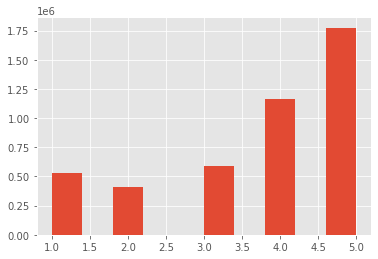

In [0]:
plt.hist(yelp_review['review_stars'])

(array([1533464.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 2938966.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

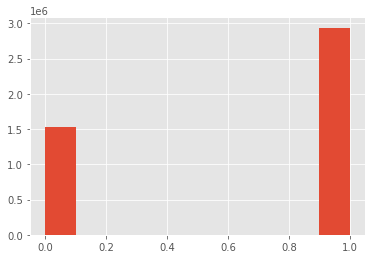

In [0]:
plt.hist(yelp_review['positive_rating'])

In [0]:
# no. of user ratings by user
user_ratings = yelp_review['user_id'].value_counts()

In [0]:
user_ratings.describe()

count    1.179034e+06
mean     3.793300e+00
std      1.260833e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      3.153000e+03
Name: user_id, dtype: float64

In [0]:
# the large majority of users are infrequent reviewers
# lets investigate heavy users...
percentile = [0.8, 0.85, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99]

for i in percentile:
  print ('{}th percentile : {} reviews, {} out of {} users'.format(int(i*100), user_ratings.quantile(i), int(i * len(user_ratings)), len(user_ratings)))

80th percentile : 4.0 reviews, 943227 out of 1179034 users
85th percentile : 5.0 reviews, 1002178 out of 1179034 users
90th percentile : 7.0 reviews, 1061130 out of 1179034 users
95th percentile : 12.0 reviews, 1120082 out of 1179034 users
96th percentile : 14.0 reviews, 1131872 out of 1179034 users
97th percentile : 18.0 reviews, 1143662 out of 1179034 users
98th percentile : 24.0 reviews, 1155453 out of 1179034 users
99th percentile : 40.0 reviews, 1167243 out of 1179034 users


####**pre-processing**

pre-processing list
* convert  all capital  letters  to  lowercase in  order  to  reduce  redundancy
* Remove  stop  words  (common  words  in  English,  but with  no sentiment information) from  the  text  reviews using   Porter corpus   of   stop   words   from   Natural Language Toolkit(NLTK).
> * https://www.researchgate.net/profile/Andreea_Salinca/publication/300415236_Business_Reviews_Classification_Using_Sentiment_Analysis/links/5718b4be08ae986b8b79f962/Business-Reviews-Classification-Using-Sentiment-Analysis.pdf






In [0]:
#importing the libraries required
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#importing required libraries
from bs4 import BeautifulSoup
import string
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [0]:
#remove html content
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    hmtl_free = soup.get_text()
    return hmtl_free

In [0]:
#removing any punctuations
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct

In [0]:
#stripping the new lines \n
def strip_(text):
    text = re.sub("[!@#$%^&*()[]{};:,./<>?\|`~-=_+]", " ", text)
    text = text.replace("\n","")
    return text.strip()

In [0]:
#tokenizing the text
def tokenize_(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)


In [0]:
#removing stop words
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words


In [0]:
#lemmattzing the text
def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [0]:
def clean_text(df):
    '''
    Take in a Dataframe, and process it
    '''
    df["cleaned_text"] = df.text.map(lambda text:text.lower()).map(remove_html).map(remove_punctuation).map(strip_).map(tokenize_).map(remove_stopwords)
    return df


In [0]:
yelp_review.columns

yelp_review_subset = yelp_review[['text', 'review_stars']]


In [0]:
yelp_review_subset['sentiment'] = ['pos' if (x>3) else 'neg' for x in yelp_review_subset['review_stars']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
yelp_review_pos = yelp_review_subset.loc[yelp_review_subset['sentiment'] == 'pos']
yelp_review_neg = yelp_review_subset.loc[yelp_review_subset['sentiment'] == 'neg']



In [0]:
#balance data set
frames = [yelp_review_pos[0:25000], yelp_review_neg[0:25000]]
df = pd.concat(frames)
from sklearn.utils import shuffle
df = shuffle(df)



In [0]:
len(df)

50000

In [0]:
import time
t0 = time.time()
import multiprocessing as mp
cores = mp.cpu_count()
partitions = 4
pool = mp.Pool(processes = cores)
data_split = np.array_split(df, partitions)
data = pd.concat(pool.map(clean_text, data_split))
pool.close()
pool.join()
t1 = time.time()
print("Time to process with parallel processing {}".format(t1-t0))

Time to process with parallel processing 482.5151686668396


In [0]:
y = df['sentiment']



# SVM implementation 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

In [0]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
print(vectors.shape)
X = vectors

(50000, 62515)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1337)

In [0]:
svm = LinearSVC()
svm.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
predictions = svm.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score
print("The accuracy with Support vector machines  "+ str(accuracy_score(y_test, predictions)))

The accuracy with Support vector machines  0.8139


# Logistic regression

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
predictions = logreg.predict(X_test)

In [0]:
print("The accuracy with Logistic Regression "+str(accuracy_score(y_test, predictions)))

The accuracy with Logistic Regression 0.8199


# LSTM (KERAS) RNN

In [0]:
%tensorflow_version 1.x
import tensorflow

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding,CuDNNLSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [0]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(data['text'].values)


In [0]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(40000, 999) (40000, 2)
(10000, 999) (10000, 2)


In [0]:
#kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, return_sequences=False, return_state=False, stateful=False
embed_dim = 128
lstm_out = 196
batch_size = 32

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = X.shape[1], dropout = 0.2))
#model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(CuDNNLSTM(lstm_out,kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',return_sequences=True))
model.add(CuDNNLSTM(lstm_out,kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',return_sequences=True))
model.add(CuDNNLSTM(lstm_out,kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 999, 128)          256000    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 999, 196)          255584    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 999, 196)          308896    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 196)               308896    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 1,129,770
Trainable params: 1,129,770
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',min_delta=0,patience=2,verbose=0, mode='auto')
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    X_train, Y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=256, 

    # An epoch is an iteration over the entire training data.
    epochs=1000, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.05,
    callbacks=[es]
    
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 38000 samples, validate on 2000 samples
Epoch 1/1000





38000/38000 [==============================] - 82s 2ms/step - loss: 0.5549 - acc: 0.7124 - val_loss: 0.4461 - val_acc: 0.7930
Epoch 2/1000
38000/38000 [==============================] - 68s 2ms/step - loss: 0.4345 - acc: 0.8044 - val_loss: 0.4048 - val_acc: 0.8115
Epoch 3/1000
38000/38000 [==============================] - 68s 2ms/step - loss: 0.4020 - acc: 0.8219 - val_loss: 0.4327 - val_acc: 0.8035
Epoch 4/1000
38000/38000 [==============================] - 68s 2ms/step - loss: 0.3841 - acc: 0.8317 - val_loss: 0.4248 - val_acc: 0.8130


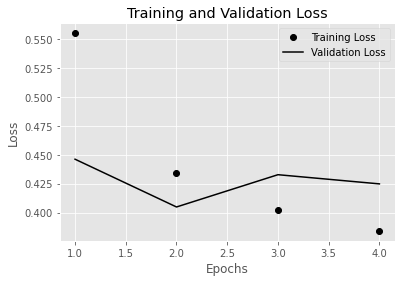

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs_ = range(1, len(loss)+1)

plt.plot(epochs_, loss, 'ko', label = 'Training Loss')
plt.plot(epochs_, val_loss, 'k', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

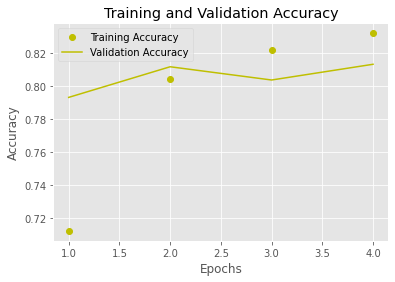

In [0]:
plt.plot(epochs_, acc, 'yo', label = 'Training Accuracy')
plt.plot(epochs_, val_acc, 'y', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [0]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 256)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 0.43
Validation Accuracy: 0.81
